In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import stats
import sncosmo
import astropy

In [25]:
train_ts = pd.read_csv("../data/input/training_set.csv")
display(train_ts.head())

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
display(train_meta.head())

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


### 試しに計算

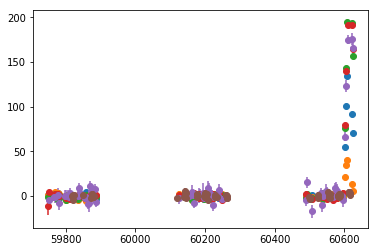

In [73]:
object_id = 19154
sample_data = train_ts.query('object_id == @object_id')
passband_dict = {0:"lsstu", 1:"lsstg", 2:"lsstr", 3:"lssti", 4:"lsstz", 5:"lssty"}

for passband in sample_data.passband.unique():
    extract_pb = sample_data.query('passband == @passband')
    plt.errorbar(extract_pb.mjd, extract_pb.flux, extract_pb.flux_err, fmt='o')

In [74]:
from scipy.optimize import fmin_l_bfgs_b
ts_data = train_ts.copy()
passband_dict = {0: "lsstu", 1: "lsstg", 2: "lsstr", 3: "lssti", 4: "lsstz", 5: "lssty"}
ts_data["passband"] = ts_data["passband"].map(passband_dict)

extract_obj = ts_data.query('object_id == @object_id')
data = astropy.table.Table(
    extract_obj.values,
    names=['object_id', 'mjd', 'band', 'flux', 'flux_err', 'detected'],
    dtype=('str', 'float', 'str', 'float', 'float', 'str')
)

photoz = train_meta.query('object_id == @object_id').hostgal_photoz.values
mwebv = train_meta.query('object_id == @object_id').mwebv.values

dust = sncosmo.CCM89Dust()
model = sncosmo.Model(
    source='salt2-extended',
    effects=[dust, dust],
    effect_names=['host', 'mw'],
    effect_frames=['rest', 'obs'])
model.set(z=photoz, mwebv=mwebv, hostebv=0, hostr_v=3.1, mwr_v=3.1)

# cutting data
data_mask = model.bandoverlap(data["band"], z=photoz).reshape(-1)
data = data[data_mask]

def objective(parameters):
    model.parameters[1:5] = parameters
    model_flux = model.bandflux(data['band'], data['mjd'])
    return np.sum(((data['flux'] - model_flux) / data['flux_err'])**2)

start_parameters = [extract_obj.mjd.min(), 0., 0., 0.]  # t0, x0, x1, c
bounds = [(extract_obj.mjd.min(), extract_obj.mjd.max()), (None, None), (None, None), (None, None)]
parameters, val, info = fmin_l_bfgs_b(objective, start_parameters, bounds=bounds, approx_grad=True)
parameters

array([ 5.97506169e+04,  2.46774625e-02,  9.62877341e-01, -2.09392992e-01])

In [86]:
train_ts_ = pd.merge(train_ts, train_meta, on="object_id")
train_ts_["dist"] = train_ts_["hostgal_photoz"] ** 2
train_ts_["flux"] = train_ts_["flux"] * train_ts_["dist"]
train_ts_["flux_err"] = train_ts_["flux_err"] * train_ts_["dist"]
train_ts_ = train_ts_.drop(['ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target', 'dist'], axis=1)

In [84]:
train_ts_.columns

Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected', 'ra',
       'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz', 'hostgal_photoz',
       'hostgal_photoz_err', 'distmod', 'mwebv', 'target', 'dist'],
      dtype='object')

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


Number of chi^2 function calls: 45
Number of degrees of freedom in fit: 285
chi^2 value at minimum: 96999.51457429327
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.41380000e+00  6.06924863e+04  5.26033704e+08 -6.48438829e-02
  3.92769796e-02  0.00000000e+00  3.10000000e+00  2.30000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


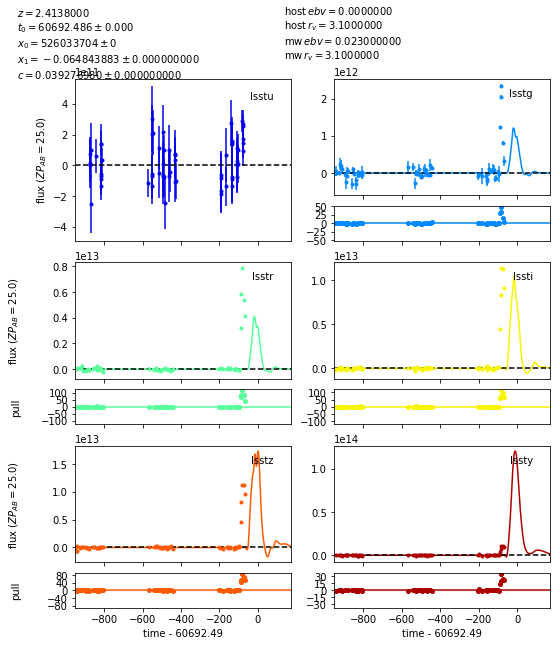

In [87]:
# create a model
# bject_id = 19154
extract_obj = train_ts_.query('object_id == @object_id')
extract_obj["passband"] = extract_obj["passband"].map(passband_dict)
#extract_obj = extract_obj.query("mjd > 60000 & mjd < 60400")

dust = sncosmo.CCM89Dust()
model = sncosmo.Model(
    source='salt2-extended',
    effects=[dust, dust],
    effect_names=['host', 'mw'],
    effect_frames=['rest', 'obs']
)
model.set(z=train_meta.query('object_id == @object_id').hostgal_photoz.values)
model.set(mwebv=train_meta.query('object_id == @object_id').mwebv.values)

data = astropy.table.Table(extract_obj.values, names=['object_id', 'mjd', 'band', 'flux', 'flux_err', 'detected'])
data["zp"] = 0
data["zpsys"] = "ab"
data["flux"] = data["flux"].astype(float)
data["flux_err"] = data["flux_err"].astype(float)

# run the fit

result, fitted_model = sncosmo.fit_lc(
    data, model,
    ['t0', 'x0', 'x1', 'c']
    )

print("Number of chi^2 function calls:", result.ncall)
print("Number of degrees of freedom in fit:", result.ndof)
print("chi^2 value at minimum:", result.chisq)
print("model parameters:", result.param_names)
print("best-fit values:", result.parameters)
print("The result contains the following attributes:\n", result.keys())
sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
plt.show()

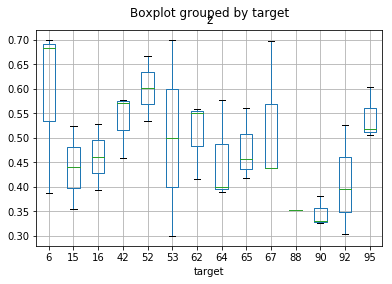

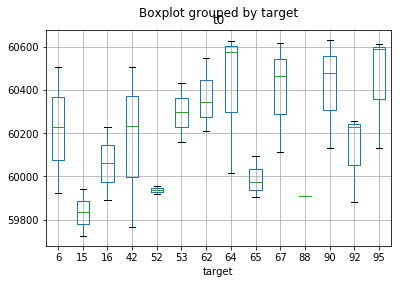

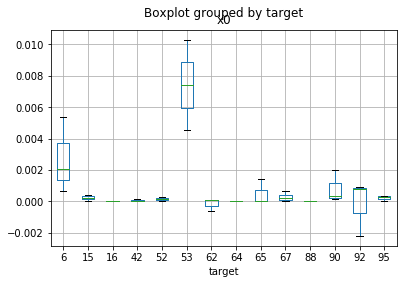

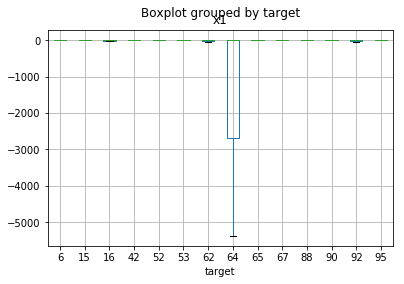

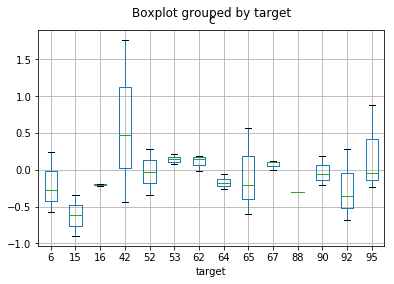

In [85]:
result_df = pd.DataFrame(result_list, columns=[
    'object_id', 'target', 'z', 't0', 'x0', 'x1', 'c'
    ])

for col in ['z', 't0', 'x0', 'x1', 'c']:
    result_df.boxplot(by='target', column=col)
    plt.show()

### zを与えた場合

In [12]:
np.sort(train_meta.target.unique())

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])

In [18]:
train_meta.query('object_id == @obj')

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
114,19154,351.382965,-64.011238,317.574052,-50.604657,1,0.2354,2.4138,0.5022,46.4553,0.023,67


In [31]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(
    source='salt2-extended',
    effects=[dust, dust],
    effect_names=['host', 'mw'],
    effect_frames=['rest', 'obs'])
model.parameters

array([0. , 0. , 1. , 0. , 0. , 0. , 3.1, 0. , 3.1])

In [38]:
def get_divided_point(obj_data):
    obj_data = obj_data.sort_values('mjd', ascending=True)
    diff_mjd = obj_data.groupby('object_id')[['mjd']].diff()

    # get points
    dist = 100
    points = obj_data[diff_mjd > dist]["mjd"].dropna().values
    points = np.concatenate([points, np.array([obj_data["mjd"].max()])])
      
    return points

In [40]:
points = get_divided_point(extract_obj)
print(points)

[60118.4163 60490.2647 60624.2132]


6 18556
6 77157
6 83348


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


15 4173


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/hakubishin3/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


15 23116
Number of chi^2 function calls: 59
Number of degrees of freedom in fit: 346
chi^2 value at minimum: 51522.643747655355
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 7.52000000e-01  6.00580911e+04 -1.57867138e+08 -3.36688924e+01
  1.11904024e+00  0.00000000e+00  3.10000000e+00  6.00000000e-03
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


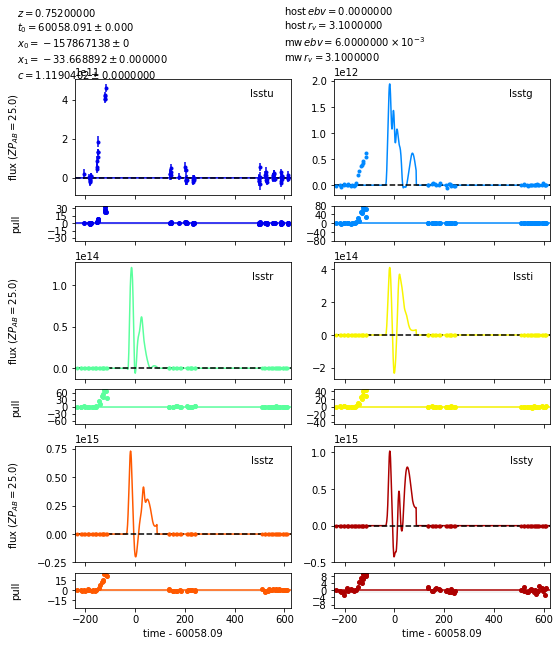

15 97406
Number of chi^2 function calls: 121
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 5073.01218806537
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 8.97000000e-02  5.97556500e+04  2.01875860e+06  1.14428488e+00
 -3.18723299e-01  0.00000000e+00  3.10000000e+00  1.90000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


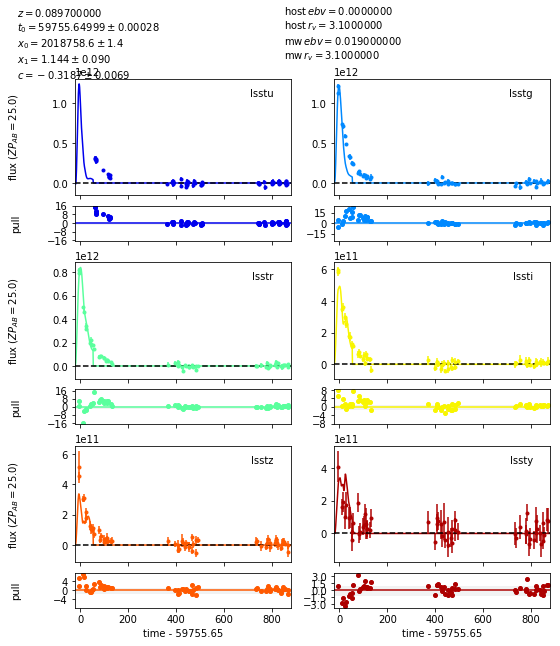

16 2677
16 4171
16 7566
42 730
Number of chi^2 function calls: 161
Number of degrees of freedom in fit: 326
chi^2 value at minimum: 2141.7503736327117
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.26200000e-01  6.05468112e+04  1.31973526e+06 -3.11072450e+00
 -1.95331812e-01  0.00000000e+00  3.10000000e+00  2.10000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


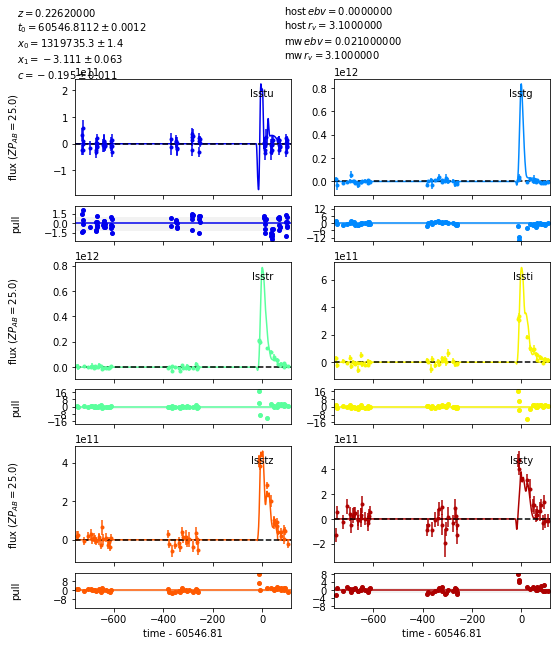

42 1632
Number of chi^2 function calls: 223
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 440.58254810031565
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [7.01400000e-01 5.97569965e+04 3.69002757e+04 7.00414406e+00
 1.58921721e+00 0.00000000e+00 3.10000000e+00 2.10000000e-02
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


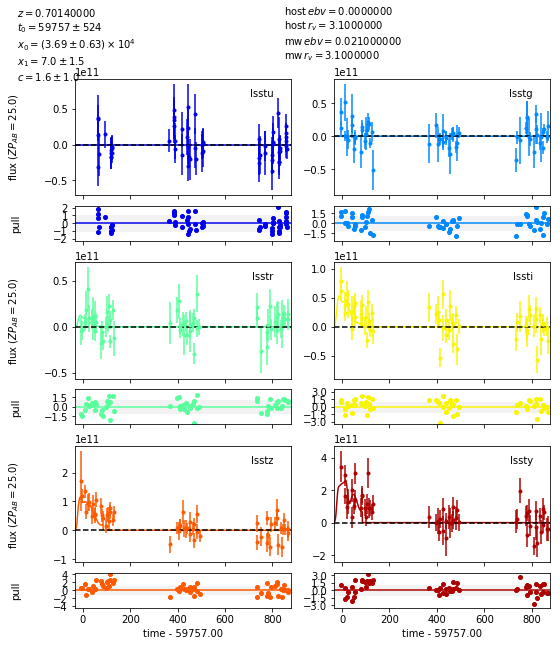

42 2103
Number of chi^2 function calls: 80
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 146785.06003225007
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 5.40900000e-01  6.02980149e+04  5.85372118e+07 -1.19465981e+01
  1.23070182e+00  0.00000000e+00  3.10000000e+00  2.00000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


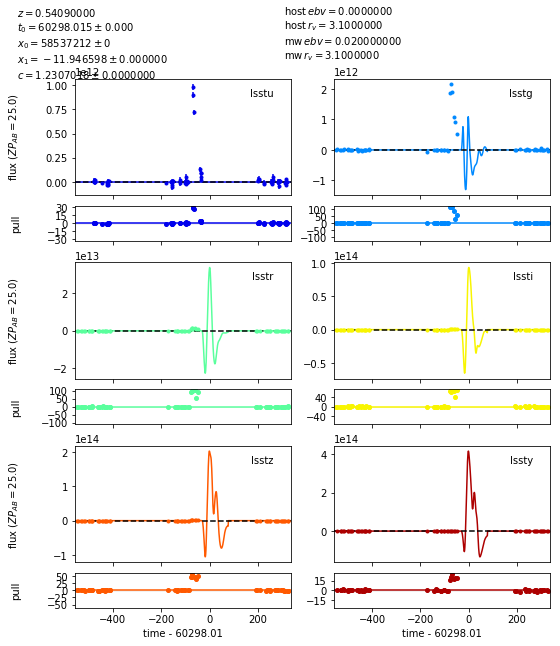

52 10757
Number of chi^2 function calls: 215
Number of degrees of freedom in fit: 346
chi^2 value at minimum: 24334.78639129411
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.71100000e-01  5.99120270e+04  3.95621639e+06 -5.32237647e-01
  2.11571431e-01  0.00000000e+00  3.10000000e+00  8.00000000e-03
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


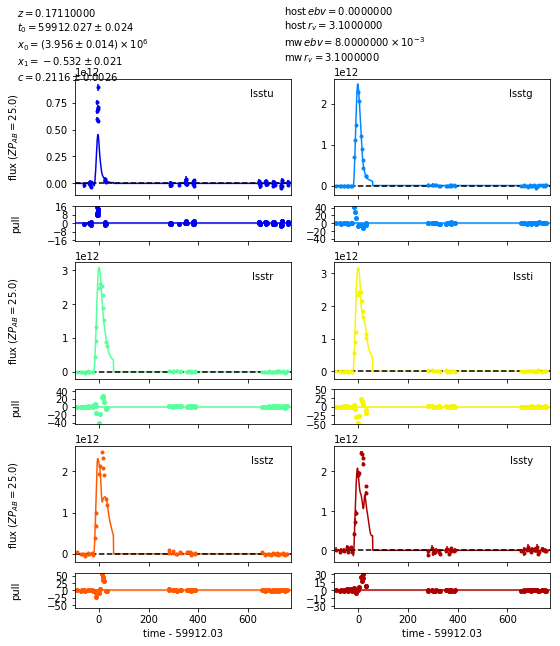

52 11773
Number of chi^2 function calls: 500
Number of degrees of freedom in fit: 251
chi^2 value at minimum: 1006.3844917776362
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [5.27900000e-01 5.99536788e+04 2.97129797e+05 5.20283477e+00
 2.65046770e-01 0.00000000e+00 3.10000000e+00 1.80000000e-02
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


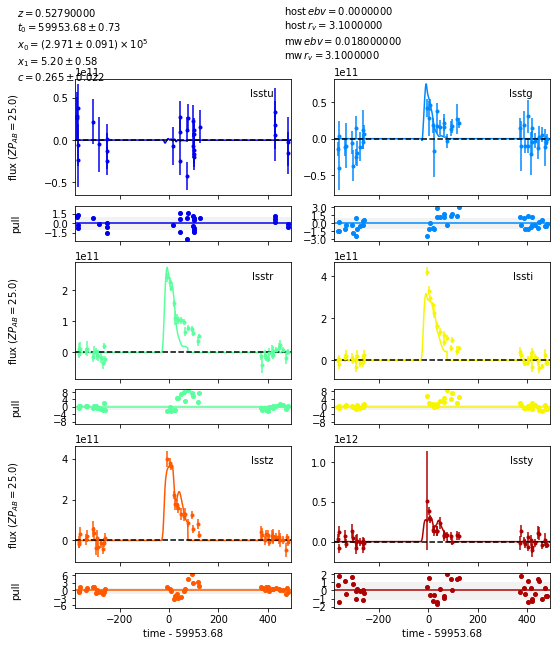

52 13138
Number of chi^2 function calls: 236
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 123491.7635052827
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 5.19200000e-01  5.97326971e+04  2.40196217e+07  1.32389572e-01
 -5.81099436e-01  0.00000000e+00  3.10000000e+00  1.90000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


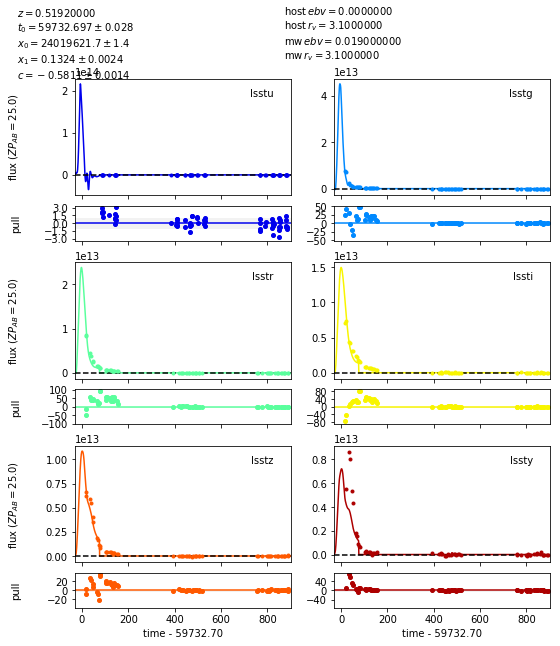

53 133773
53 268977
53 278480
62 3910


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


Number of chi^2 function calls: 258
Number of degrees of freedom in fit: 275
chi^2 value at minimum: 13329.018551502799
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [2.67660000e+00 6.05640300e+04 7.26044262e+07 3.67915461e-01
 1.84848187e-01 0.00000000e+00 3.10000000e+00 9.00000000e-03
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


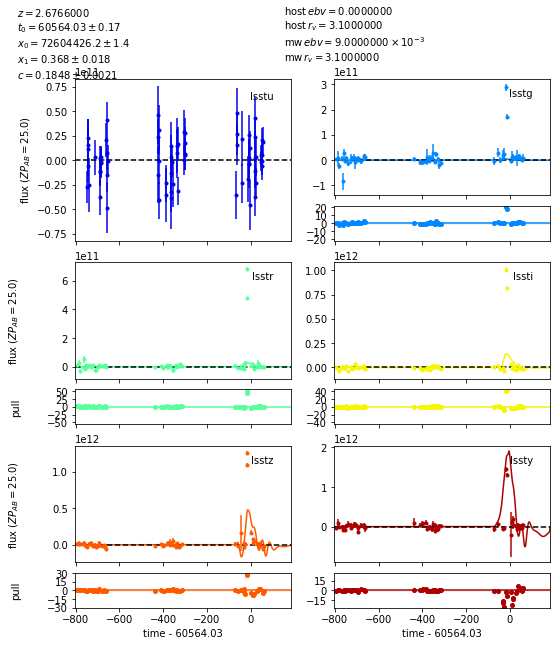

62 7703
Number of chi^2 function calls: 345
Number of degrees of freedom in fit: 346
chi^2 value at minimum: 38948.09153602706
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [8.20000000e-02 6.01581422e+04 4.47764739e+06 1.89508126e+00
 2.24337424e-01 0.00000000e+00 3.10000000e+00 7.00000000e-03
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


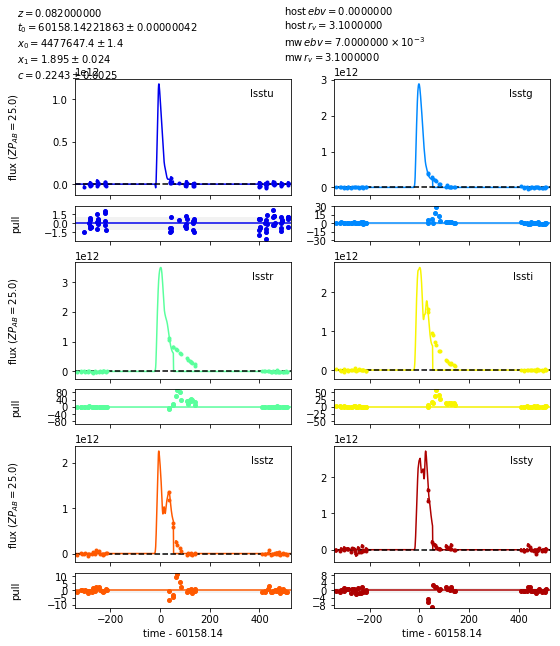

62 11770
Number of chi^2 function calls: 56
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 6144.360013863536
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.17100000e-01  6.03232549e+04  3.27358431e+06 -3.77149305e+01
 -1.16070397e+00  0.00000000e+00  3.10000000e+00  2.00000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


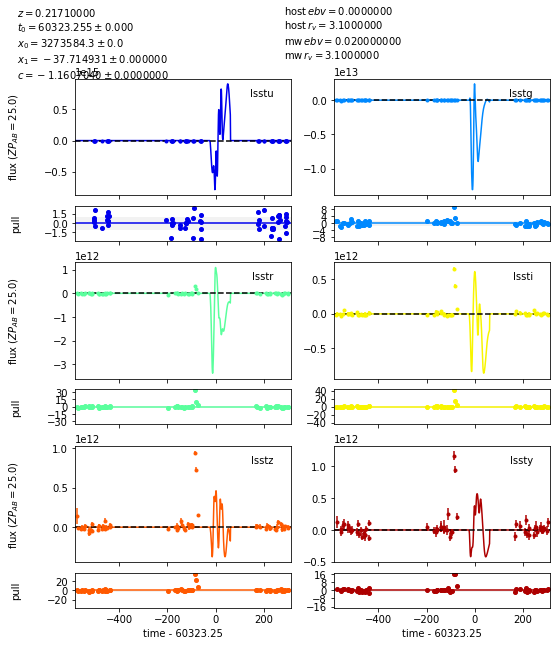

64 62187
Number of chi^2 function calls: 83
Number of degrees of freedom in fit: 326
chi^2 value at minimum: 1584.7408595193242
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.30100000e-01  6.05769767e+04  7.39693765e+05 -5.64618208e+00
 -3.51194420e-01  0.00000000e+00  3.10000000e+00  2.20000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


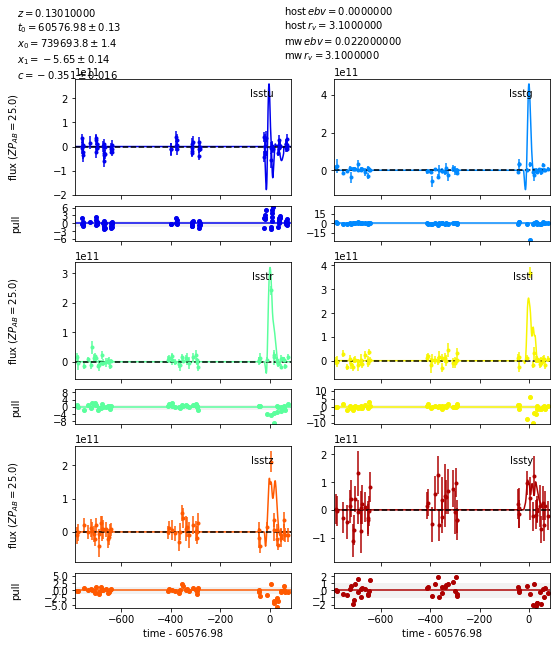

64 139362
Number of chi^2 function calls: 70
Number of degrees of freedom in fit: 251
chi^2 value at minimum: 3421.299624420539
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 7.79000000e-02  6.00107420e+04  1.10986147e+06 -6.60048165e+00
 -3.54808318e-01  0.00000000e+00  3.10000000e+00  3.30000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


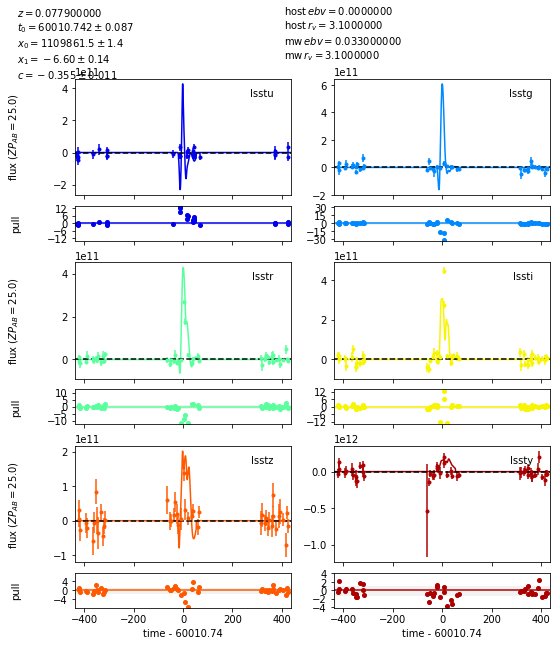

64 1573501
Number of chi^2 function calls: 211
Number of degrees of freedom in fit: 138
chi^2 value at minimum: 303.94386564062086
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.68000000e-02  6.06086295e+04  5.20824938e+07 -6.27065628e+00
 -6.54578340e-01  0.00000000e+00  3.10000000e+00  7.28000000e-01
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


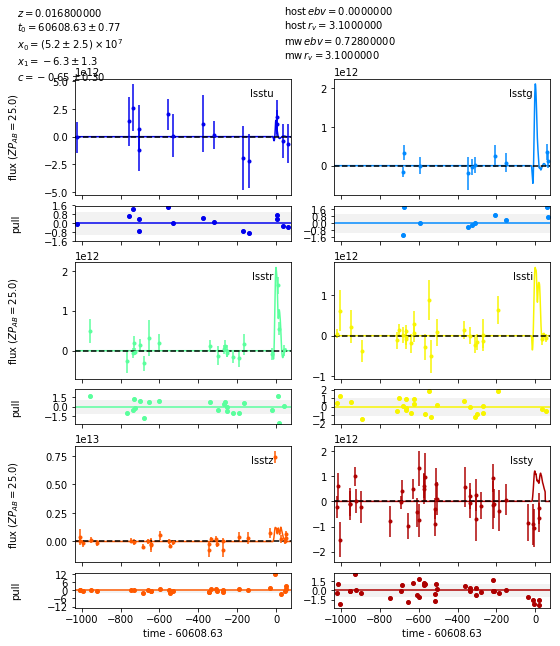

65 1227
65 1926
65 2624
67 2922
Number of chi^2 function calls: 219
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 17428.177245035637
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.46900000e-01  6.00997133e+04  1.32388644e+07 -2.80572017e+00
  1.43648874e-01  0.00000000e+00  3.10000000e+00  2.00000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


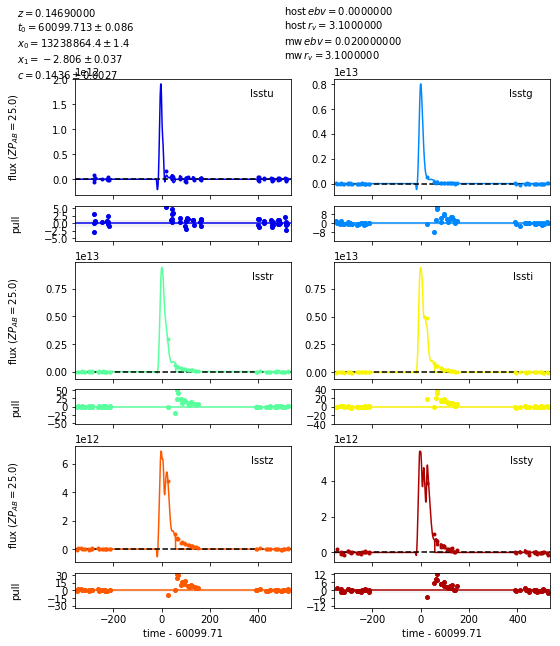

67 3041
Number of chi^2 function calls: 234
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 597.9986589493423
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.27400000e-01  6.04519398e+04  1.26923371e+06 -1.02657431e+00
  2.27894340e-01  0.00000000e+00  3.10000000e+00  2.00000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


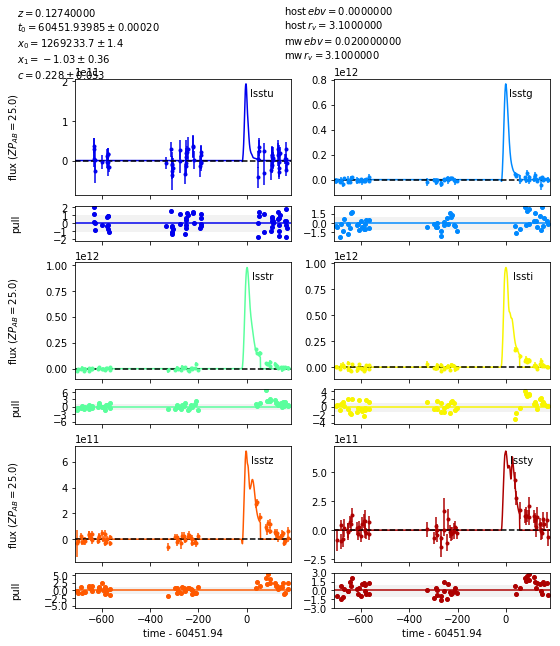

67 19154
Number of chi^2 function calls: 43
Number of degrees of freedom in fit: 285
chi^2 value at minimum: 96999.51457429293
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.41380000e+00  6.06924863e+04  9.02840444e+07 -6.48438829e-02
  3.92769796e-02  0.00000000e+00  3.10000000e+00  2.30000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


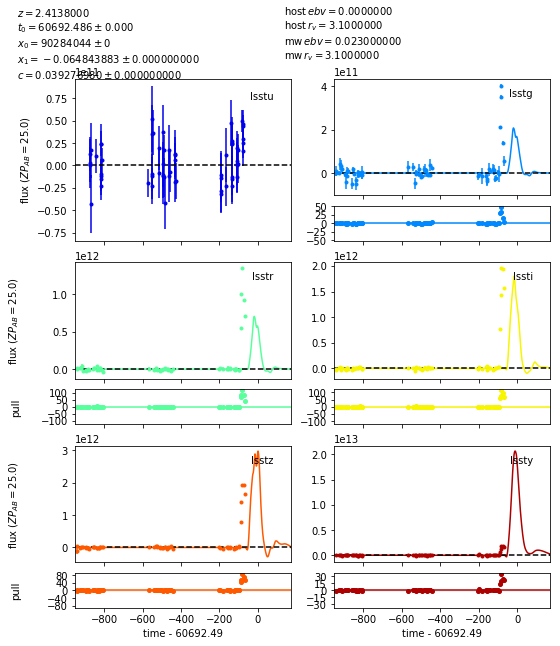

88 713
Number of chi^2 function calls: 464
Number of degrees of freedom in fit: 346
chi^2 value at minimum: 5876.262258826477
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [1.62670000e+00 5.98570347e+04 6.42587382e+06 1.10464326e+03
 2.53912964e+01 0.00000000e+00 3.10000000e+00 7.00000000e-03
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


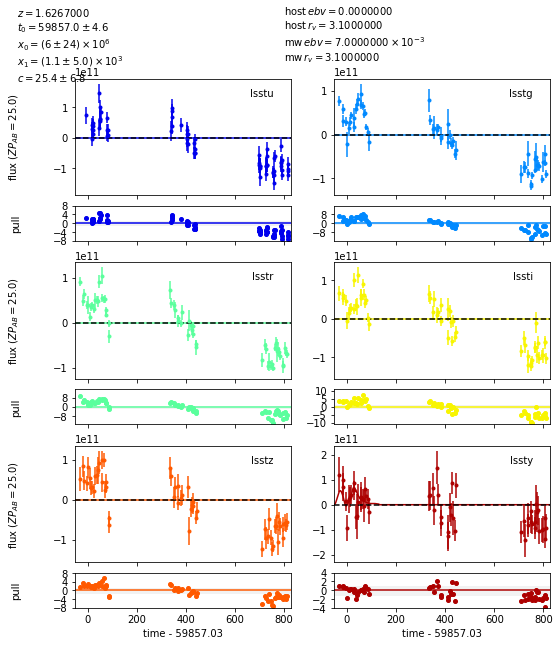

88 3489
Number of chi^2 function calls: 359
Number of degrees of freedom in fit: 251
chi^2 value at minimum: 3383.653318371036
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.43770000e+00  5.98048372e+04  3.40061886e+07 -1.42777647e+01
  5.99249109e+00  0.00000000e+00  3.10000000e+00  1.60000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


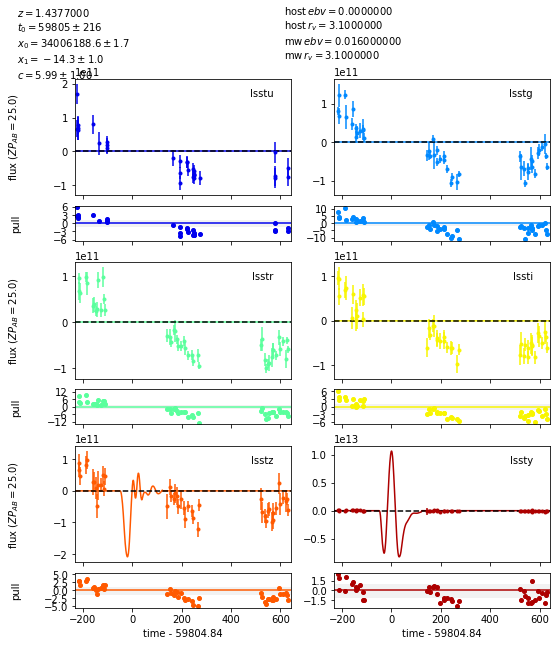

88 4088
90 745
Number of chi^2 function calls: 136
Number of degrees of freedom in fit: 347
chi^2 value at minimum: 3708.0452468867857
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.81300000e-01  6.01304691e+04  3.42261123e+06 -4.11557550e-01
 -2.02387299e-02  0.00000000e+00  3.10000000e+00  7.00000000e-03
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


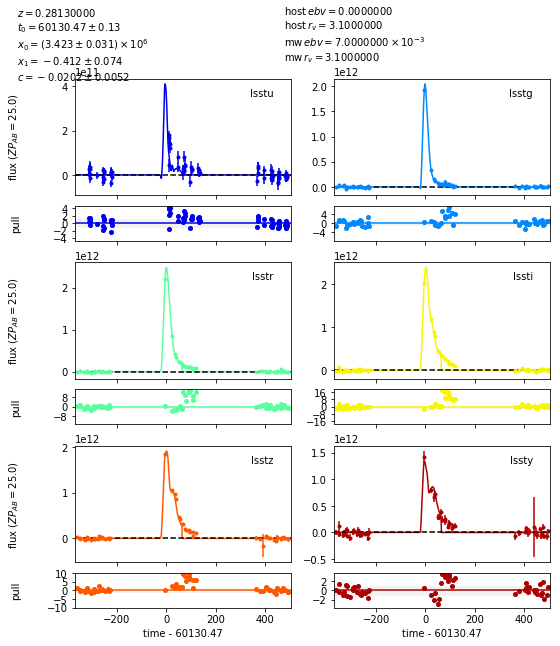

90 1124
Number of chi^2 function calls: 231
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 6765.706255252908
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 2.41500000e-01  6.04703043e+04  3.44443235e+06 -6.69438091e-01
  1.22639498e-01  0.00000000e+00  3.10000000e+00  2.40000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


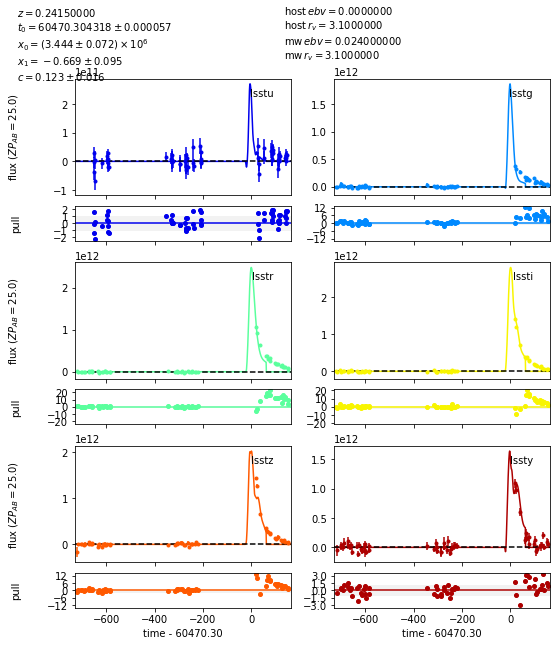

90 1598
Number of chi^2 function calls: 175
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 2010.4859306294386
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.82000000e-01  6.06290959e+04  2.28307949e+07  7.31680749e-01
 -7.38850536e-02  0.00000000e+00  3.10000000e+00  1.90000000e-02
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


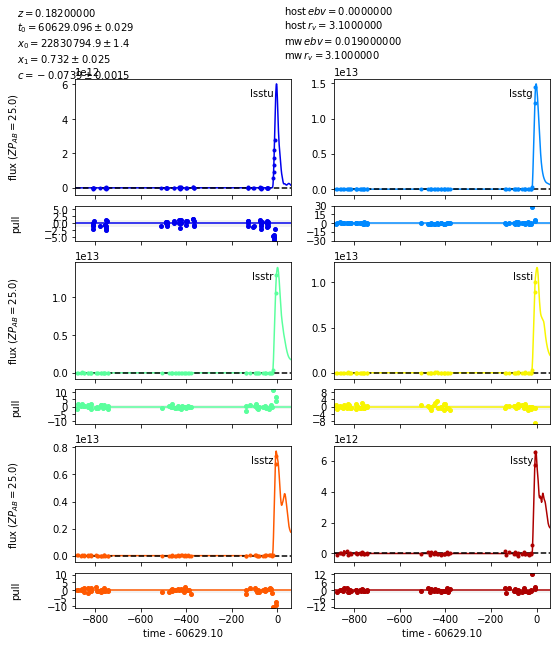

92 615
92 12695
92 26161
95 3423
Number of chi^2 function calls: 81
Number of degrees of freedom in fit: 348
chi^2 value at minimum: 445.06647455219115
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [1.12130000e+00 6.01364227e+04 2.96873433e+05 1.72434386e+00
 2.95711365e-02 0.00000000e+00 3.10000000e+00 1.80000000e-02
 3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


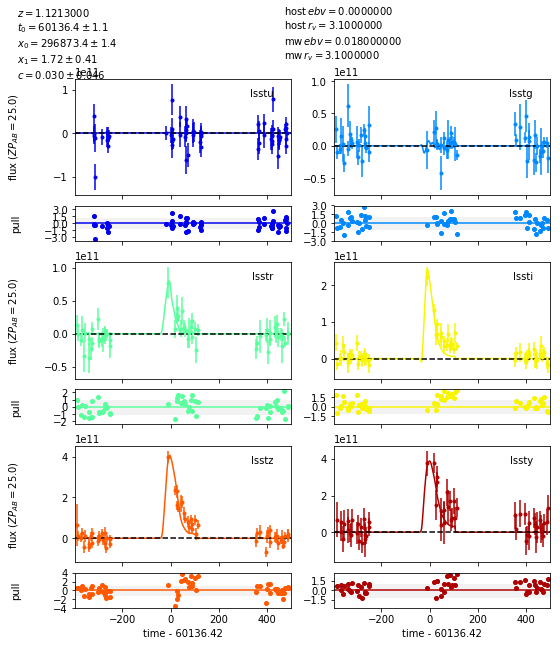

95 10321
Number of chi^2 function calls: 467
Number of degrees of freedom in fit: 347
chi^2 value at minimum: 528405.9573869389
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']
best-fit values: [ 1.11620000e+00  6.05774258e+04  2.40530562e+06  1.26096166e+01
 -8.96176125e-02  0.00000000e+00  3.10000000e+00  9.00000000e-03
  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])


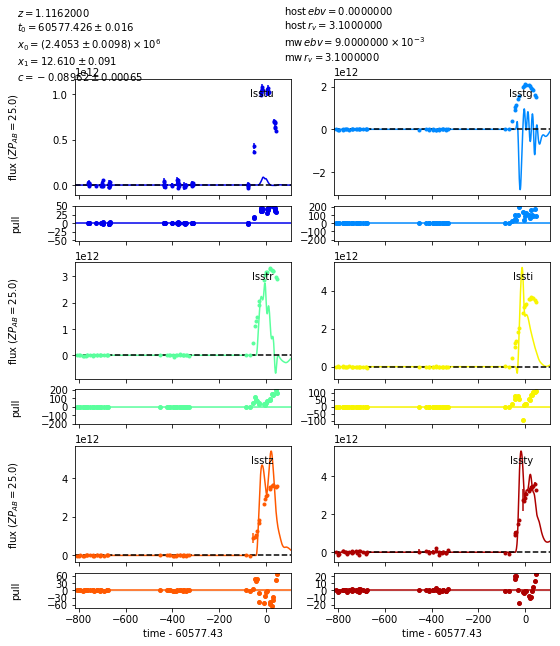

95 14553


In [39]:
result_list = []
for target in np.sort(train_meta.target.unique()):
    objects = train_meta.query('target==@target').object_id.head(3).values
    for obj in objects:
        print(target, obj)
        extract_obj = train_ts.query('object_id==@obj')
        extract_obj["passband"] = extract_obj["passband"].map(passband_dict)
        
        
        if train_meta.query('object_id == @obj').hostgal_photoz.values==0:
            continue

        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(
            source='salt2-extended',
            effects=[dust, dust],
            effect_names=['host', 'mw'],
            effect_frames=['rest', 'obs'])

        data = astropy.table.Table(extract_obj.values, names=['object_id', 'mjd', 'band', 'flux', 'flux_err', 'detected'])
        data["zp"] = 0
        data["zpsys"] = "ab"
        data["flux"] = data["flux"].astype(float)
        data["flux_err"] = data["flux_err"].astype(float)

        # run the fit
        model.set(z=train_meta.query('object_id == @obj').hostgal_photoz.values)
        model.set(mwebv=train_meta.query('object_id == @obj').mwebv.values)
        try:
            result, fitted_model = sncosmo.fit_lc(
                data, model,
                ['t0', 'x0', 'x1', 'c'])
        except:
            continue

        print("Number of chi^2 function calls:", result.ncall)
        print("Number of degrees of freedom in fit:", result.ndof)
        print("chi^2 value at minimum:", result.chisq)
        print("model parameters:", result.param_names)
        print("best-fit values:", result.parameters)
        print("The result contains the following attributes:\n", result.keys())
        sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
        plt.show()
        
        result_list.append([object_id, target]+list(result.parameters))

In [40]:
result_df = pd.DataFrame(result_list, columns=[
    'object_id', 'target', 'z', 't0', 'x0', 'x1', 'c'
    ])

for col in ['z', 't0', 'x0', 'x1', 'c']:
    result_df.boxplot(by='target', column=col)
    plt.show()

AssertionError: 7 columns passed, passed data had 11 columns

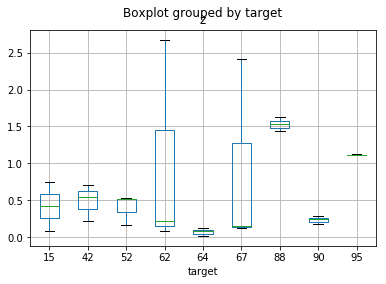

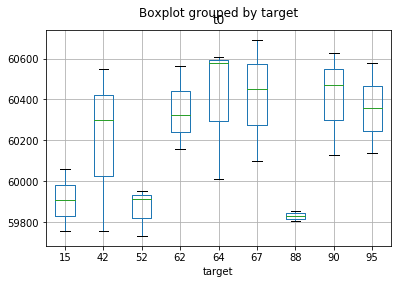

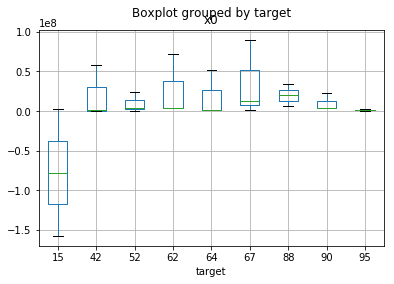

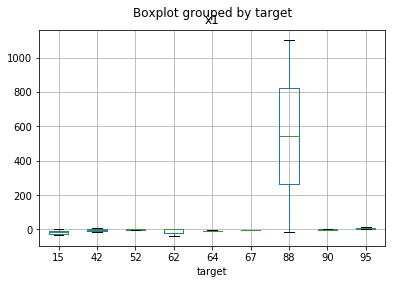

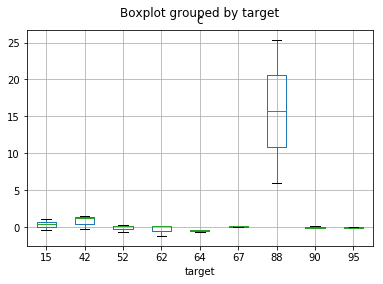

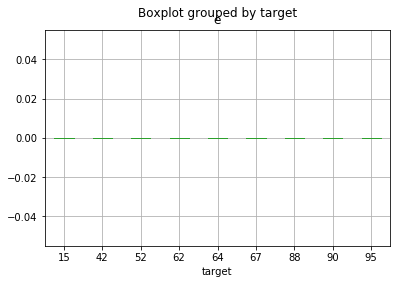

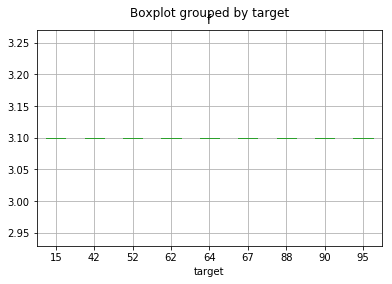

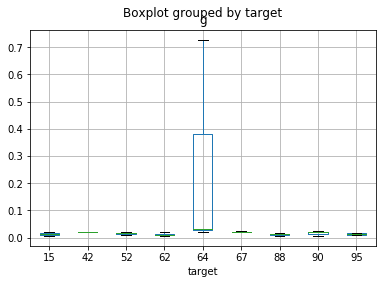

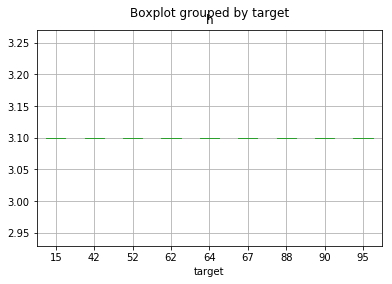

In [45]:
result_df = pd.DataFrame(result_list, columns=[
    'object_id', 'target', 'z', 't0', 'x0', 'x1', 'c', 'e', 'f', 'g', 'h'
    ])

for col in ['z', 't0', 'x0', 'x1', 'c', 'e', 'f', 'g', 'h']:
    result_df.boxplot(by='target', column=col)
    plt.show()

In [44]:
result_list

[[19154,
  15,
  0.752,
  60058.09106994421,
  -157867138.28029332,
  -33.66889239198684,
  1.1190402447028305,
  0.0,
  3.1,
  0.006,
  3.1],
 [19154,
  15,
  0.0897,
  59755.649988904785,
  2018758.6008713301,
  1.1442848791531612,
  -0.31872329890710954,
  0.0,
  3.1,
  0.019,
  3.1],
 [19154,
  42,
  0.2262,
  60546.81115595099,
  1319735.2585389568,
  -3.1107245023052417,
  -0.1953318116865811,
  0.0,
  3.1,
  0.021,
  3.1],
 [19154,
  42,
  0.7014,
  59756.9964697347,
  36900.275745239676,
  7.004144059726054,
  1.5892172141947825,
  0.0,
  3.1,
  0.021,
  3.1],
 [19154,
  42,
  0.5409,
  60298.01487353812,
  58537211.76753135,
  -11.946598106312113,
  1.2307018241643035,
  0.0,
  3.1,
  0.02,
  3.1],
 [19154,
  52,
  0.1711,
  59912.026957904854,
  3956216.386229866,
  -0.5322376470807341,
  0.21157143128327557,
  0.0,
  3.1,
  0.008,
  3.1],
 [19154,
  52,
  0.5279,
  59953.678801194175,
  297129.79725080787,
  5.202834773509532,
  0.26504676959881374,
  0.0,
  3.1,
  0.0180000

In [76]:
import FATS

SyntaxError: invalid syntax (Feature.py, line 93)